In [1]:
#Python dependencies
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import codata

In [2]:
#change the default font set (matplotlib.rc)
mpl.rc('mathtext', fontset='stixsans', default='regular')

#increase text size somewhat
mpl.rcParams.update({'axes.labelsize':12, 'font.size': 12})

In [3]:
#set up notebook for inline plotting
%matplotlib inline

In [4]:
#get constants from CODATA 2010
F = codata.physical_constants['Faraday constant'][0]
R = codata.physical_constants['molar gas constant'][0]
EPSILON_0 = codata.physical_constants['electric constant'][0]
#check the constants
F,R,EPSILON_0

(96485.3365, 8.3144621, 8.854187817620389e-12)

# Double-Layer Capacitance

The following is based mainly on the treatment presented in the book by Oldham, Myland, and Bond: [Electrochemical Science and Technology](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0470710853.html).
Other excellent introductions to electrical double-layers can be found in the books [Electrochemical Methods](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0471043729.html) by Bard & Faulkner and in [Electrochemical Systems](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0471477567.html) by Newman and Thomas-Alyea.

### Definition of Capacitance

Capacitance is defined as the ratio of charge, $Q$, and voltage (potential difference), $V$, across the capacitor:

$$C = \dfrac{Q}{V}$$

In electrochemical cells the capacitance usually varies somewhat with the electrode potential, so it is useful to think of capacitance as a differential quantity, i.e. $C_{differential} = C_{d} = \dfrac{\mathrm{d}Q}{\mathrm{d}V}$ or $C_{d} = \dfrac{\mathrm{d}Q}{\mathrm{d}E}$ for a single electrode, with the electrode potential $E$.

The integral capacitance is given by 

$$C_{integral} = \dfrac{Q(E)}{E-E_{zc}} = \dfrac{1}{E-E_{zc}} \int_{E_{zc}}^E {C_{d}}\mathrm{d}E$$

where $Q$ is a function of $E$ and $E_{zc}$ is the *potential of zero charge*.

### Capacitance of a Parallel Plate Capacitor

A parallel plate capacitor basically is a two-terminal device that can be used to store energy electrostatically. The capacitance of a parallel plate capacitor is given by:

$$C_{pp} = \dfrac{\epsilon \epsilon_0 A}{x}$$

where $\epsilon$ is the relative static permittivity (dielectric constant), $\epsilon_0$ is the permittivity of free space [F m$^{-1}$], and A and x are the area and distance between the plates, respectively.

### Capacitance of the Helmholtz Layer

The Helmholtz model is essentially a parallel plate capacitor model, and thus the capacitance of the Helmholtz layer is given by:

$$\dfrac{C_{H}}{A} = \dfrac{\mathrm{d}q}{\mathrm{d}E}= \dfrac{\epsilon_H \epsilon_0}{x_H}$$

where $q$ is the charge density, $\epsilon_H$ is the relative dielectric constant of the Helmholtz layer, $\epsilon_0$ is the permittivity of free space [F], and $A$ and $x_H$ are the area of the electrode and the thickness of the Helmholtz layer, respectively.

In [5]:
def cap_helmholtz(epsilon_H=6.8, x=0.2e-9, A=1e-4):
    """
    *input*
    epsilon_H - the relative permittivity of the Helmholtz layer, default is 6.8
    x, the thickness of the Helmholtz layer [m], default is 0.2 nm, i.e. 0.2e-9 cm.
    A, electrode area [m²], default is 1 cm², i.e. 1e-4
    *output*
    C,  [F]
    """
    C_H = (epsilon_H*EPSILON_0*A)/x
    return C_H

The relative permittivity of bulk water at 25$\,^{\circ}{\rm C}$ is 78.5. The solvent molecules and ions in the Helmholtz (or compact) layer are confined in a narrow region and ordered by an intense local electric field, leading to significantly lower relative permittivities than their corresponding bulk values. For water some estimates suggests it could be as low as 5 for water molecules in the inner Helmholtz layer and around 30 for water molecules in the outer Helmholtz layer. 

To take into account different relative permittivities we have to divide the Helmholtz layer into a number of series connected parallel plate capacitors, but to keep things simple we will treat it as if it had only a single permittivity here. 

In [6]:
#For a Helmholtz layer thickness of 0.2 nm (roughly half the diameter of a hydrated cation), and a relative permittivity of 5:
print(round(cap_helmholtz(5,0.2e-9,100e-6),7), 'F')

2.21e-05 F


### Capacitance of the Diffuse Layer
The Gouy-Chapman model predicts the capacitance of the diffuse double layer to be given by (for a 1:1 electrolyte and monovalent ions):

$$ \dfrac{C_{GC}}{A} = \sqrt{\dfrac{2 F^2 \epsilon \epsilon_0 c}{RT}} \mathrm{cosh} \left[ \dfrac{F}{2RT} (E-E_{zc}) \right] $$

where $c$ is the concentration of the electrolyte (i.e. $c = c_{cation} = c_{anion}$) in the solution.

### The Stern Model
The total double layer capacitance can be modeled using a series combination of the Gouy-Chapman model, which models the capacitance of the diffuse double-layer, and the Helmholtz model, which describes the capacitance of the compact double layer that is located closest to the electrode surface, as suggested originally by Stern. This is sometimes referred to as the Gouy-Chapman-Stern model, or just the Stern model.

The total capacitance of the two layers would thus be:

$$\dfrac{1}{C_S} = \dfrac{1}{C_H} + \dfrac{1}{C_{GC}}$$

In [7]:
def cap_gouychapman(E,Epz=0,c=10,T=298.15,epsilon=78.54,A=1e-4):
    """
    *input*
    E, electrode potential [V]
    Epz, potential of zero charge [V], default is 0 V
    c [mol/m³], default is 10 mM, i.e. 10e-3 mol/dm³ = 10 mol/m³ 
    T [K], default is 298.15 K
    epsilon [dimensionless]
    A, the electrode area in m²    
    *output*
    C_GC_spec, the capacitance (C_GC) of  
    the diffuse double layer as predicted by the Gouy-Chapman model for  
    a 1:1 electrolyte with monovalent ions.
    """
    C_GC = A*np.sqrt((2*(F**2)*epsilon*EPSILON_0*c)/(R*T))*np.cosh(F*(E-Epz)/(2*R*T))
    return C_GC

def cap_stern(E,Epz=0,epsilon_H=6.8,x=0.2e-9,c=10,T=298.15,epsilon=78.54,A=1e-4):
    """Returns the total double-layer capacitance as predicted by the
       Gouy-Chapman-Stern model"""
    C_h = cap_helmholtz(epsilon_H=epsilon_H,x=x,A=A)
    C_gc = cap_gouychapman(E,Epz=Epz,c=c,T=T,epsilon=epsilon,A=A)
    recip_C_S = 1/C_h + 1/C_gc
    return 1/recip_C_S

### Relationship between Capacitance and Electrode Potential

In the following we will use [matplotlib](http://matplotlib.org/) to visualize the relationship between capacitance and electrode potential around the potential of zero charge. 

In [8]:
#generate a range of potentials
E = np.linspace(-0.2,0.2, num=401)
E[:5] #check the first five values in the array

array([-0.2  , -0.199, -0.198, -0.197, -0.196])

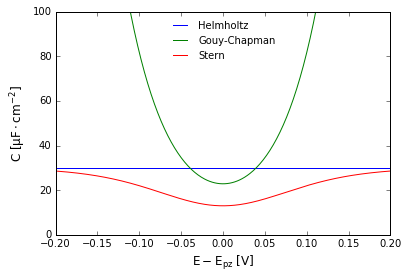

In [13]:
#now plot the component capacitances and the total as well
fig, ax = plt.subplots(nrows=1, ncols=1)

#plot the data,multiply by 1e6 to get µF
ax.plot(E, 1e6*cap_helmholtz()*np.ones(len(E)), 'b-', label='Helmholtz')
ax.plot(E, 1e6*cap_gouychapman(E), 'g-', label='Gouy-Chapman')
ax.plot(E, 1e6*cap_stern(E), 'r-', label='Stern')

#set axis labels
ax.set_xlabel('$E-E_{pz}$ [V]')
ax.set_ylabel('C [$\mu F \cdot cm^{-2}$]')

#set axis limits
ax.set_ylim(0,100)
ax.set_xlim(-0.2,0.2)

#figure legend
ax.legend(loc='best', ncol=1, frameon=False, fontsize=10)

#savefig
#plt.savefig('double-layer-cap_vs_potential.png', dpi=200)

plt.show()

### Total Capacitance as a Function of Electrolyte Concentration

Still considering a 1:1 electrolyte with monovalent ions, but now we'll calculate the total capacitance as a function of the electrolyte concentration.

In [10]:
#electrolyte concentrations (in M)

c_electrolyte_M = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5] 

#electrolyte concentration (convert to array and to units of mol/m³ and then back again to a list)

c_electrolyte = list(np.array(c_electrolyte_M)*1e3)

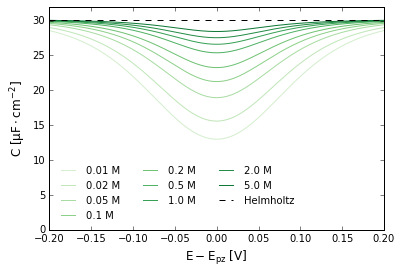

In [11]:
#now plot the component capacitances and the total as well
fig, ax = plt.subplots(nrows=1, ncols=1)

cmap = plt.cm.Greens(xrange(50,255,20))

#plot the data,multiply by 1e6 to get µF
for i,conc in enumerate(c_electrolyte):
    ax.plot(E, 1e6*cap_stern(E, c=conc), ls='-', color=cmap[i], label=str(conc/1e3)+' M')
    
ax.plot(E, 1e6*cap_helmholtz()*np.ones(len(E)), 'k--', label='Helmholtz')

#set axis labels
ax.set_xlabel('$E-E_{pz}$ [V]')
ax.set_ylabel('C [$\mu F \cdot cm^{-2}]$')

#figure legend
ax.legend(loc='best', ncol=3, frameon=False, fontsize=10)

#set axis limits
ax.set_ylim(0,32)
ax.set_xlim(-0.2,0.2)

#save figure
#plt.savefig('double-layer-cap_vs_conc.png', dpi=200)

plt.show()